In [8]:
import os
import re
import sys
from collections import Counter
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import FrenchStemmer
from nltk.tokenize import word_tokenize
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from scipy.stats import spearmanr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
# Local application imports
sys.path.insert(0, '../Utility files')
import utils2
from utils2 import *
from model_comparison import CrossValidation


### General overview

In [9]:
#Load all user coordinates
user_coords = utils2.load_all_row_coords_files(9)

# Load the coordinate files for models 1 to 9
job_coords = utils2.load_CA_model_files(9)

#Load the marker coords
marker_coords = utils2.load_all_column_coords_files(9)


Used file path: /home/livtollanes/NewData/coordinates/m1_coords/m1_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m2_coords/m2_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m3_coords/m3_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m4_coords/m4_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m5_coords/m5_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m6_coords/m6_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m7_coords/m7_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m8_coords/m8_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m9_coords/m9_row_coordinates.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m1_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m2_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job

In [45]:
for i in range(2):
    min_val_user = user_coords[i]['0'].min()
    max_val_user = user_coords[i]['0'].max()
    min_val_marker = marker_coords[i]['0'].min()
    max_val_marker = marker_coords[i]['0'].max()

    print(f"For Df{i+1}:")
    print(f"Coordinate ranges in dim0 for Users: {min_val_user}, {max_val_user}")
    print(f"Coordinate ranges in dim0 for Markers: {min_val_marker}, {max_val_marker}")
    print("\n")

For Df1:
Coordinate ranges in dim0 for Users: -1.857363747620658, 2.373286995730377
Coordinate ranges in dim0 for Markers: -1.4740972213055, 1.8887795369498348


For Df2:
Coordinate ranges in dim0 for Users: -2.196695399016296, 2.0237896424507795
Coordinate ranges in dim0 for Markers: -1.7640850325575554, 1.588087699932512




General distribution - markers and users

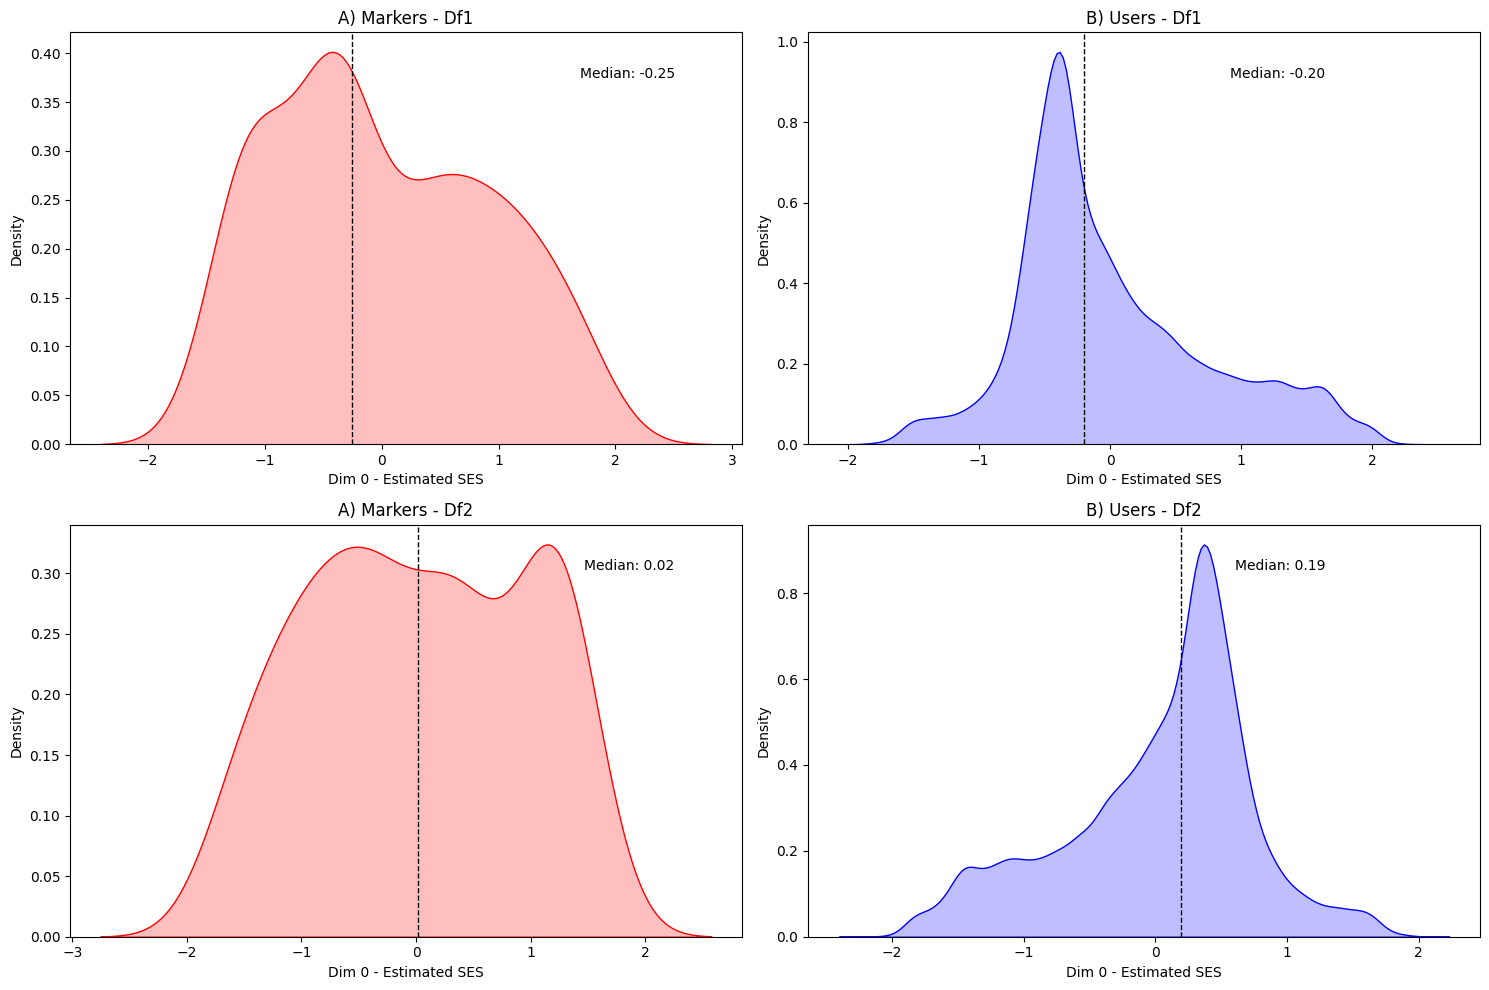

In [3]:

#Kernal density estimate plot
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
for i in range(2):
    # Plot the density of '0' for marker_coords[i]
    data = marker_coords[i]['0']
    sns.kdeplot(data, ax=axs[i, 0], color='red', fill=True)
    axs[i, 0].set_xlabel('Dim 0 - Estimated SES')
    axs[i, 0].set_ylabel('Density')
    axs[i, 0].set_title(f'A) Markers - Df{i + 1}')
    
    # Add a vertical line for the median of marker_coords[i]
    median_marker = np.median(data)
    axs[i, 0].axvline(median_marker, color='black', linestyle='dashed', linewidth=1)
    axs[i, 0].text(0.9, 0.9, f'Median: {median_marker:.2f}', horizontalalignment='right', verticalalignment='center', transform=axs[i, 0].transAxes)
    # Plot the density of '0' for user_coords[i]
    data = user_coords[i]['0']
    sns.kdeplot(data, ax=axs[i, 1], color='blue', fill=True)
    axs[i, 1].set_xlabel('Dim 0 - Estimated SES')
    axs[i, 1].set_ylabel('Density')
    axs[i, 1].set_title(f'B) Users - Df{i+1}')
    
    # Add a vertical line for the median of user_coords[i]
    median_user = np.median(data)
    axs[i, 1].axvline(median_user, color='black', linestyle='dashed', linewidth=1)
    axs[i, 1].text(0.77, 0.9, f'Median: {median_user:.2f}', horizontalalignment='right', verticalalignment='center', transform=axs[i, 1].transAxes)
plt.tight_layout()
plt.show()


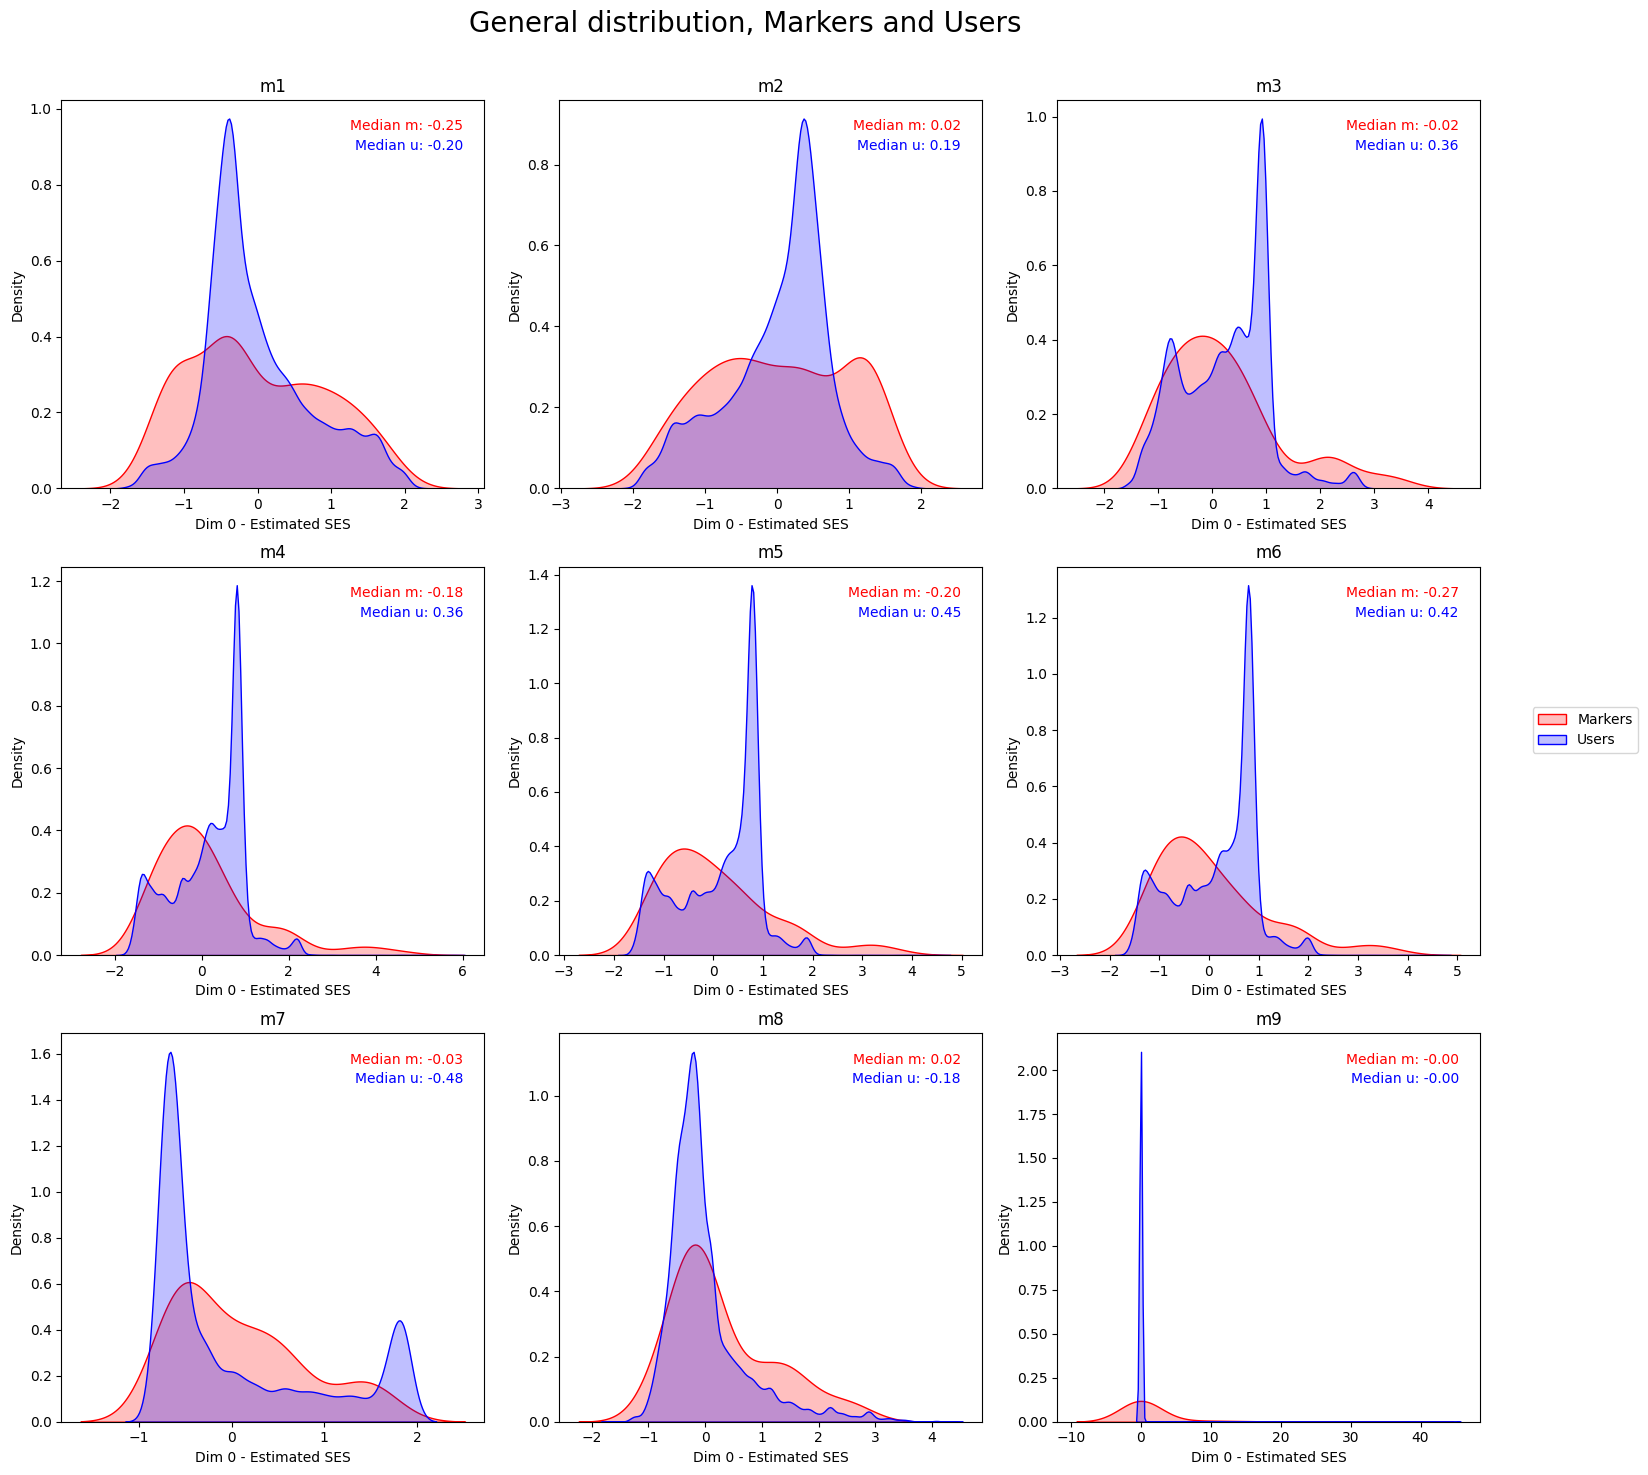

In [7]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('General distribution, Markers and Users', fontsize=20)

# Flatten the axes array to loop over it
axs = axs.flatten()

# Loop over each DataFrame in marker_coords
for i in range(len(marker_coords)):
    # Plot the density of '0' for marker_coords[i]
    sns.kdeplot(marker_coords[i]['0'], color='red', fill=True, label='Markers', ax=axs[i])

    # Plot the density of '0' for user_coords[i]
    sns.kdeplot(user_coords[i]['0'], color='blue', fill=True, label='Users', ax=axs[i])

    # Calculate medians
    median_markers = marker_coords[i]['0'].median()
    median_users = user_coords[i]['0'].median()

    # Add text to the upper right corner
    axs[i].text(0.95, 0.95, f'Median m: {median_markers:.2f}', horizontalalignment='right', verticalalignment='top', transform=axs[i].transAxes, color='red')
    axs[i].text(0.95, 0.90, f'Median u: {median_users:.2f}', horizontalalignment='right', verticalalignment='top', transform=axs[i].transAxes, color='blue')

    # Set the labels and title for the current subplot
    axs[i].set_xlabel('Dim 0 - Estimated SES')
    axs[i].set_ylabel('Density')
    axs[i].set_title(f'm{i+1}')

# Create a single legend for the entire figure
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.1, 0.5))

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

General distribution - marker types

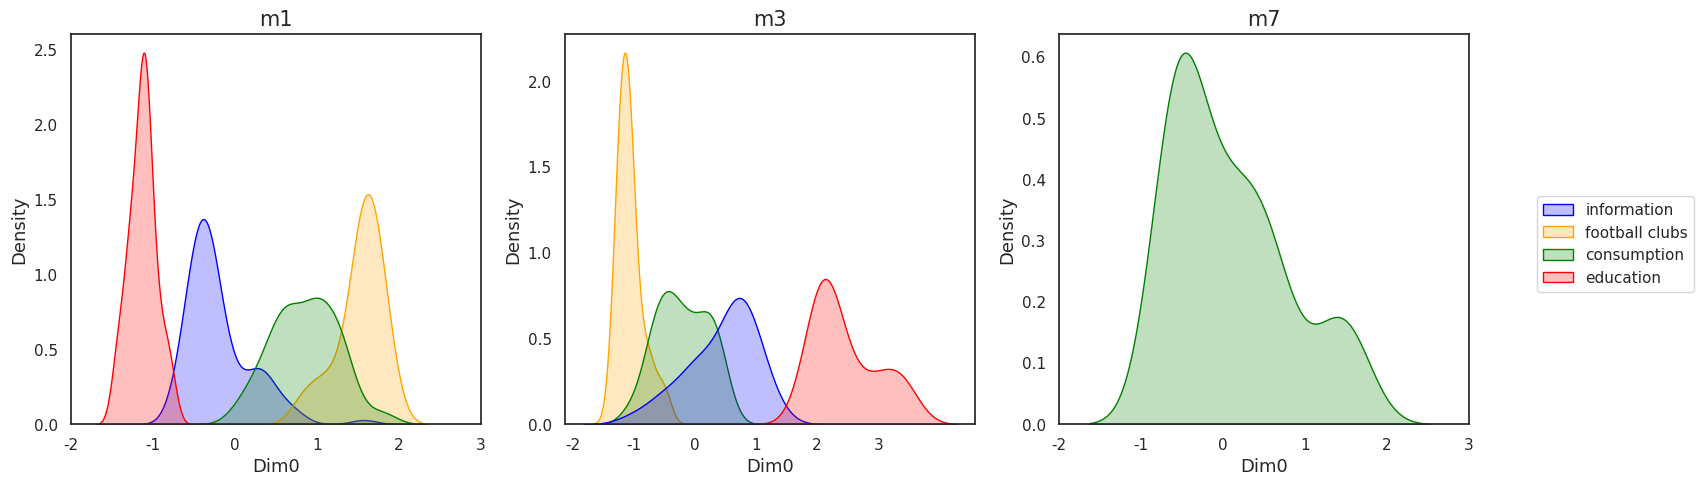

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
# Set the style of the plot
sns.set(style="white")
# Define a color dictionary for each type
color_dict = {'information': 'blue', 'football clubs': 'orange', 'consumption': 'green', 'education': 'red'}
# Create a 1x2 grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Flatten the axes array to loop over it
axs = axs.flatten()

# Create a list of the DataFrames to plot
dfs = [marker_coords[0], marker_coords[2], marker_coords[6]]
# Create a list of the DataFrame numbers
df_nums = [1, 3, 7]

# Determine the range and step for the x-axis ticks
x_ticks = range(-2, 4, 1)

# Loop over the DataFrames in dfs
for i, df in enumerate(dfs):
    # Loop over each type2 in the current DataFrame
    for type2 in df['type2'].unique():
        # Subset to the type2
        subset = df[df['type2'] == type2]
        # Draw the density plot with the color corresponding to the type on the current subplot
        sns.kdeplot(subset['0'], label = type2, fill = True, color=color_dict[type2], ax=axs[i])
    # Set the labels and title, using the corresponding DataFrame number, for the current subplot
    axs[i].set_xlabel('Dim0', size=13)
    axs[i].set_ylabel('Density', size=13)
    axs[i].set_title(f'm{df_nums[i]}', size=15)
    # Set the x-axis ticks and labels for the current subplot
    axs[i].set_xticks(x_ticks)
    axs[i].set_xticklabels(x_ticks)
# Create a single legend for the entire figure
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.14, 0.5))
# Adjust the layout of the figure
plt.tight_layout()
# Adjust the main title to avoid overlap with the subplot titles
plt.subplots_adjust(top=0.92)
# Show the plot
plt.show()

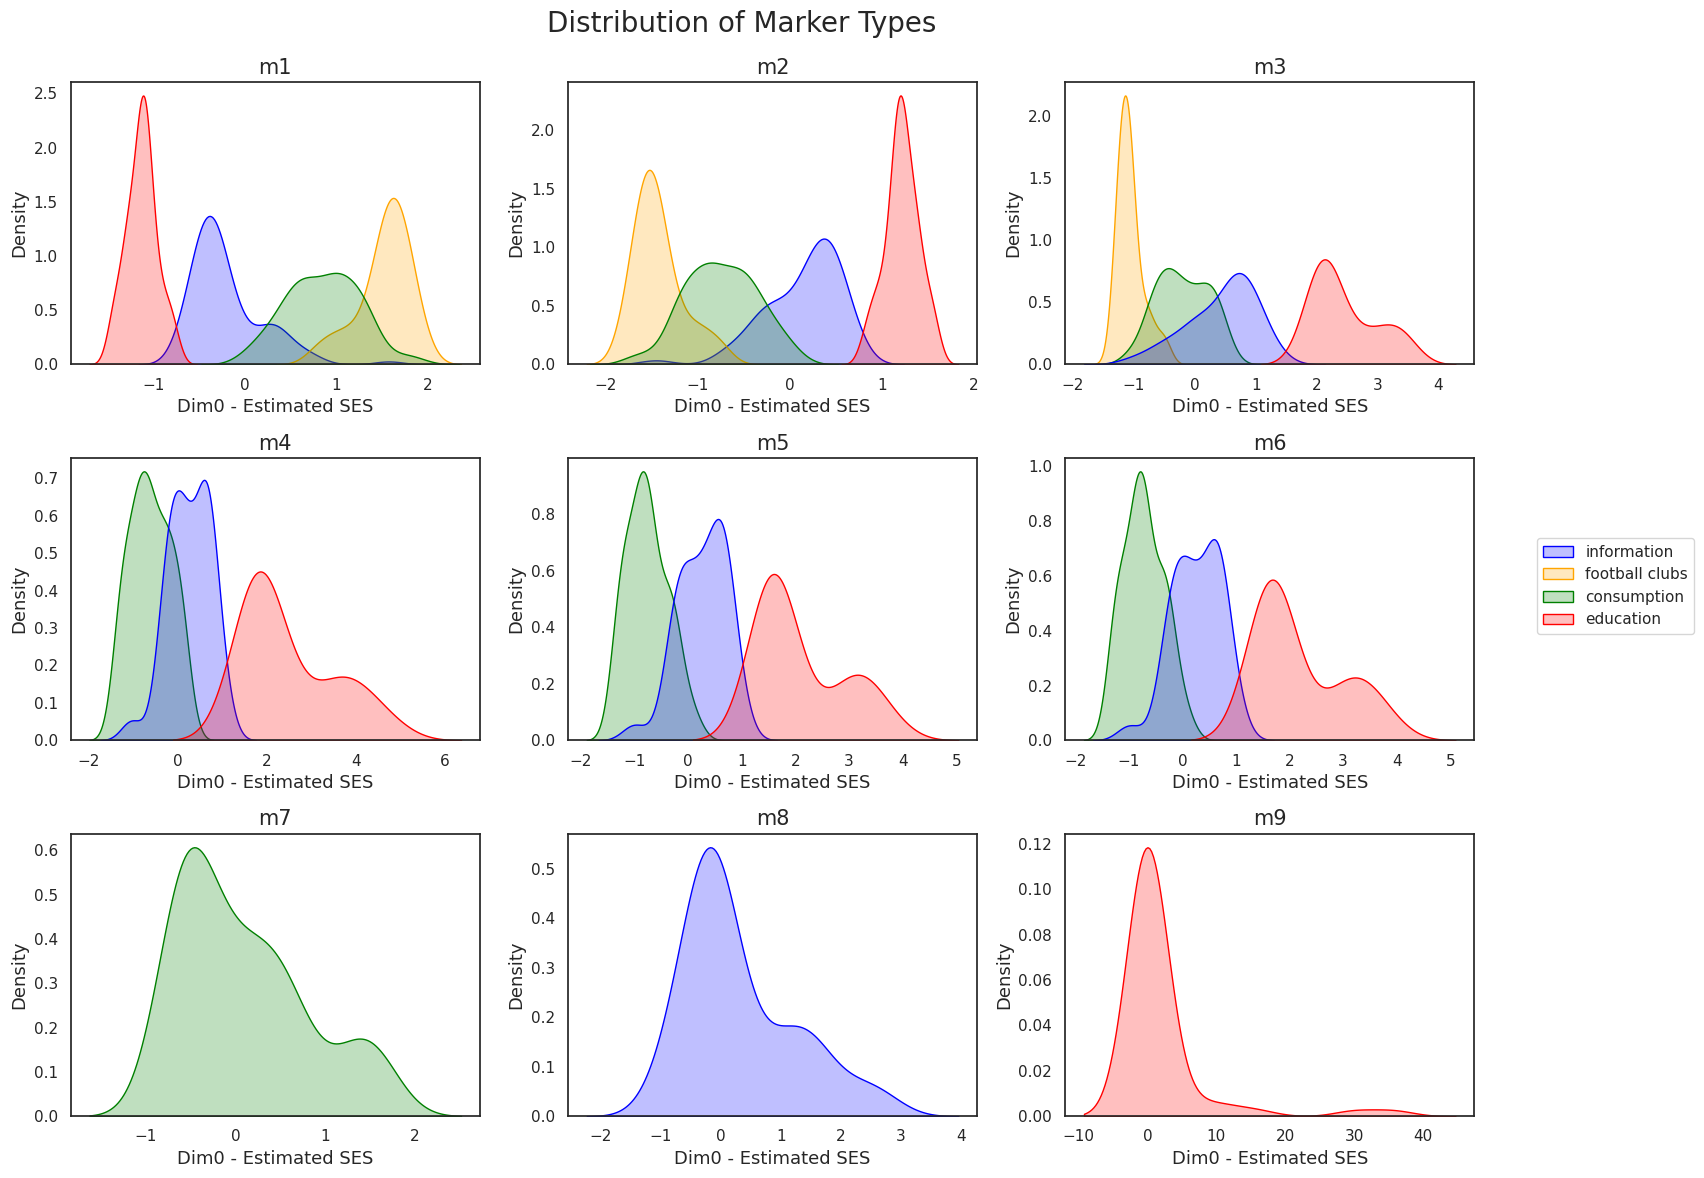

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
# Set the style of the plot
sns.set(style="white")
# Define a color dictionary for each type
color_dict = {'information': 'blue', 'football clubs': 'orange', 'consumption': 'green', 'education': 'red'}
# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 12))
# Add a main title to the figure
fig.suptitle('Distribution of Marker Types', fontsize=20)
# Flatten the axes array to loop over it
axs = axs.flatten()
# Loop over each DataFrame in marker_coords
for i in range(len(marker_coords)):
    # Loop over each type2 in the current DataFrame
    for type2 in marker_coords[i]['type2'].unique():
        # Subset to the type2
        subset = marker_coords[i][marker_coords[i]['type2'] == type2]
        # Draw the density plot with the color corresponding to the type on the current subplot
        sns.kdeplot(subset['0'], label = type2, fill = True, color=color_dict[type2], ax=axs[i])
    # Set the labels and title, including the DataFrame number, for the current subplot
    axs[i].set_xlabel('Dim0 - Estimated SES', size=13)
    axs[i].set_ylabel('Density', size=13)
    axs[i].set_title(f'm{i+1}', size=15)
# Create a single legend for the entire figure
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.14, 0.5))
# Adjust the layout of the figure
plt.tight_layout()
# Adjust the main title to avoid overlap with the subplot titles
plt.subplots_adjust(top=0.92)
# Show the plot
plt.show()


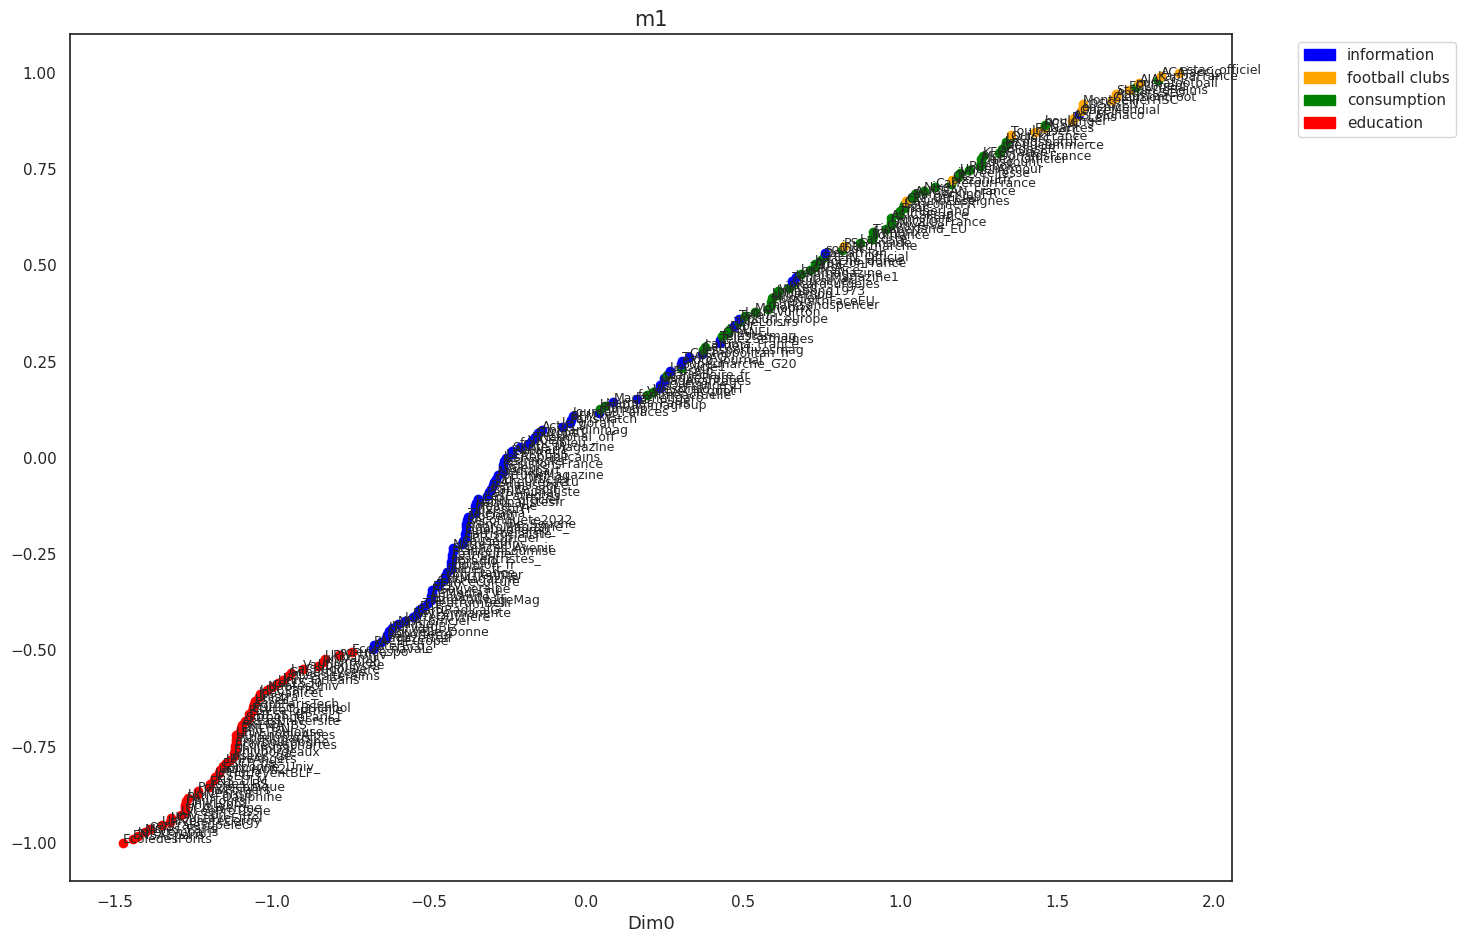

In [87]:
import numpy as np
import matplotlib.patches as mpatches

# Select the first DataFrame
df = dfs[0]

# Create a new figure
plt.figure(figsize=(15, 11))

# Define the color dictionary
color_dict = {'information': 'blue', 'football clubs': 'orange', 'consumption': 'green', 'education': 'red'}

# Sort the entire DataFrame by the '0' column
df = df.sort_values('0')

# Generate evenly spaced y-values for all data points
y_values = np.linspace(-1, 1, len(df))

# Add scatterplot for each 'twitter_name' in the DataFrame
for name in df['twitter_name'].unique():
    name_subset = df[df['twitter_name'] == name]
    type2_color = color_dict[name_subset['type2'].iloc[0]]  # Get the color for the current type2
    plt.scatter(name_subset['0'], y_values[df['twitter_name'] == name], color=type2_color)
    # Add label to the plot
    for x, y in zip(name_subset['0'], y_values[df['twitter_name'] == name]):
        plt.text(x, y, name, fontsize=9)

# Set the labels and title
plt.xlabel('Dim0', size=13)
plt.title('m1', size=15)

# Create a legend
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in color_dict.items()]
plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

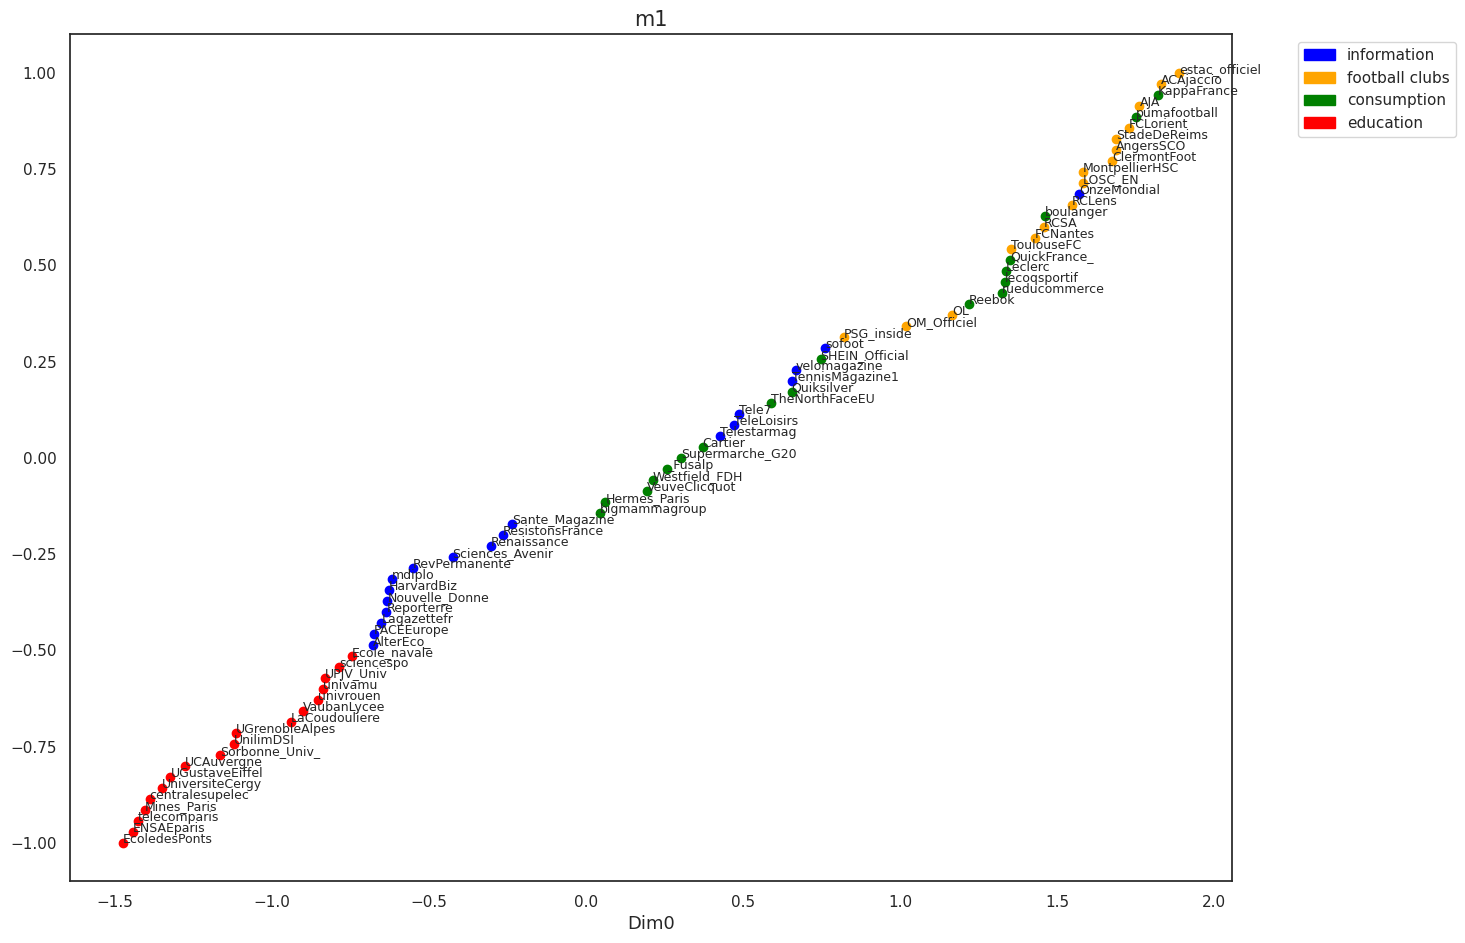

In [110]:
import numpy as np
import matplotlib.patches as mpatches

# Define the number of points to select from each group
num_points = 7

# Select the first DataFrame
df = dfs[0]

# Create a new figure
plt.figure(figsize=(15, 11))

# Define the color dictionary
color_dict = {'information': 'blue', 'football clubs': 'orange', 'consumption': 'green', 'education': 'red'}

# Create an empty DataFrame to store the selected markers
selected_markers = pd.DataFrame()

# Select the num_points lowest, num_points middle, and num_points highest markers from each 'type2'
for type2 in df['type2'].unique():
    type2_subset = df[df['type2'] == type2]
    lowest = type2_subset.nsmallest(num_points, '0')
    highest = type2_subset.nlargest(num_points, '0')
    middle = type2_subset.iloc[len(type2_subset)//2-num_points//2:len(type2_subset)//2+num_points//2] if len(type2_subset) > num_points-1 else type2_subset.iloc[[len(type2_subset)//2]]
    selected_markers = pd.concat([selected_markers, lowest, middle, highest])

# Remove duplicates
selected_markers = selected_markers.drop_duplicates(subset='twitter_name')

# Sort the selected markers by the '0' column
selected_markers = selected_markers.sort_values('0')

# Generate evenly spaced y-values for the selected markers
y_values = np.linspace(-1, 1, len(selected_markers))

# Add scatterplot for each 'twitter_name' in the selected markers
for name in selected_markers['twitter_name'].unique():
    name_subset = selected_markers[selected_markers['twitter_name'] == name]
    type2_color = color_dict[name_subset['type2'].iloc[0]]  # Get the color for the current type2
    plt.scatter(name_subset['0'], y_values[selected_markers['twitter_name'] == name], color=type2_color)
    # Add label to the plot
    for x, y in zip(name_subset['0'], y_values[selected_markers['twitter_name'] == name]):
        plt.text(x, y, name, fontsize=9)

# Set the labels and title
plt.xlabel('Dim0', size=13)
plt.title('m1', size=15)

# Create a legend
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in color_dict.items()]
plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

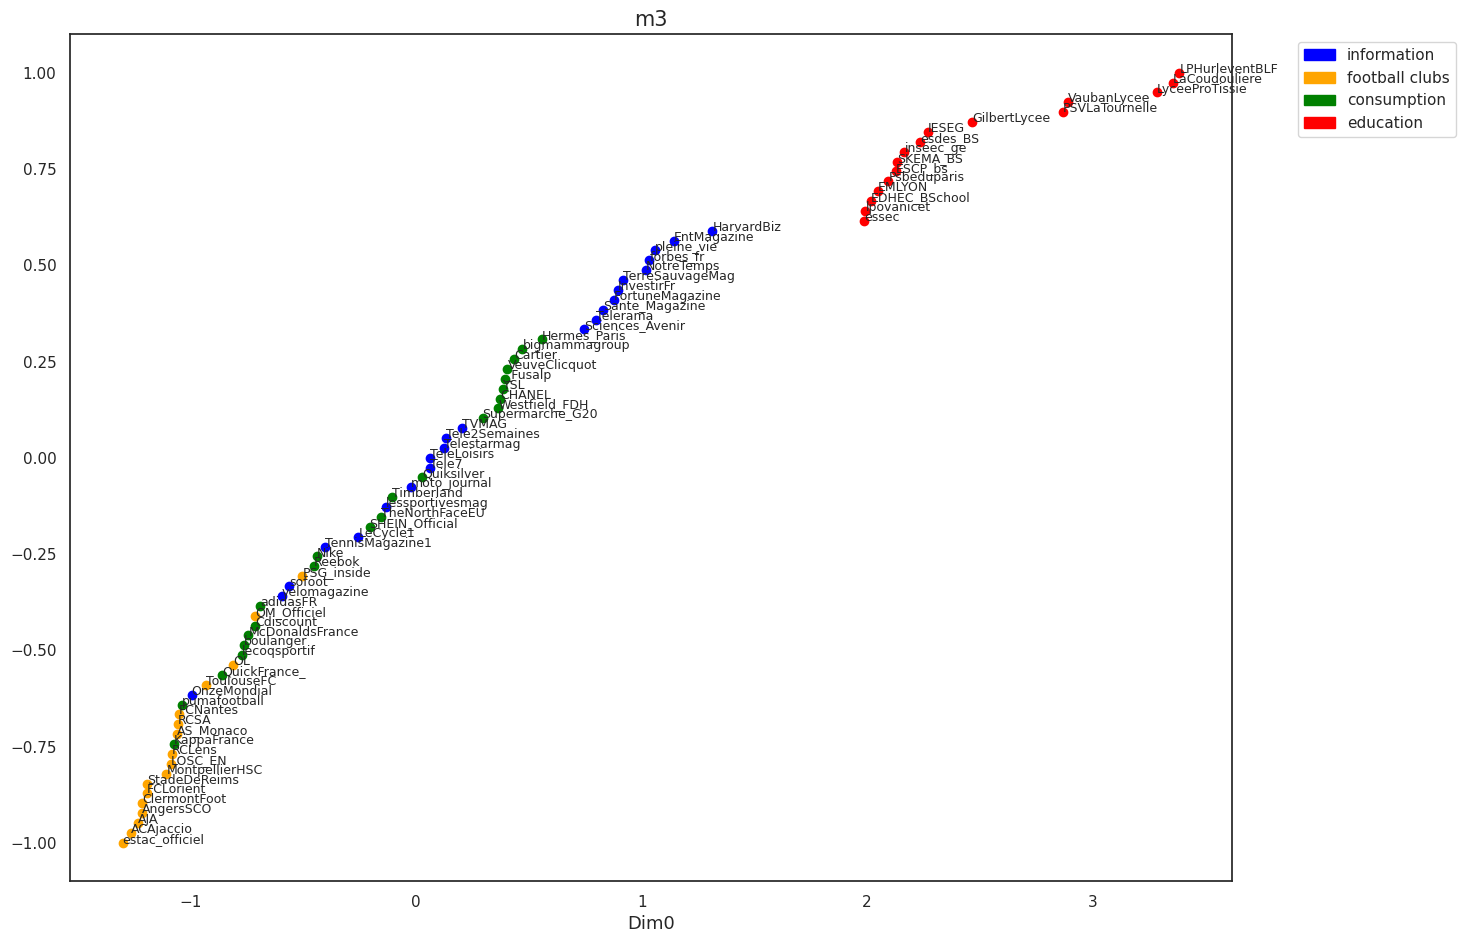

In [108]:
import numpy as np
import matplotlib.patches as mpatches

# Define the number of points to select from each group
num_points = 8

# Select the first DataFrame
df = dfs[1]

# Create a new figure
plt.figure(figsize=(15, 11))

# Define the color dictionary
color_dict = {'information': 'blue', 'football clubs': 'orange', 'consumption': 'green', 'education': 'red'}

# Create an empty DataFrame to store the selected markers
selected_markers = pd.DataFrame()

# Select the num_points lowest, num_points middle, and num_points highest markers from each 'type2'
for type2 in df['type2'].unique():
    type2_subset = df[df['type2'] == type2]
    lowest = type2_subset.nsmallest(num_points, '0')
    highest = type2_subset.nlargest(num_points, '0')
    middle = type2_subset.iloc[len(type2_subset)//2-num_points//2:len(type2_subset)//2+num_points//2] if len(type2_subset) > num_points-1 else type2_subset.iloc[[len(type2_subset)//2]]
    selected_markers = pd.concat([selected_markers, lowest, middle, highest])

# Remove duplicates
selected_markers = selected_markers.drop_duplicates(subset='twitter_name')

# Sort the selected markers by the '0' column
selected_markers = selected_markers.sort_values('0')

# Generate evenly spaced y-values for the selected markers
y_values = np.linspace(-1, 1, len(selected_markers))

# Add scatterplot for each 'twitter_name' in the selected markers
for name in selected_markers['twitter_name'].unique():
    name_subset = selected_markers[selected_markers['twitter_name'] == name]
    type2_color = color_dict[name_subset['type2'].iloc[0]]  # Get the color for the current type2
    plt.scatter(name_subset['0'], y_values[selected_markers['twitter_name'] == name], color=type2_color)
    # Add label to the plot
    for x, y in zip(name_subset['0'], y_values[selected_markers['twitter_name'] == name]):
        plt.text(x, y, name, fontsize=9)

# Set the labels and title
plt.xlabel('Dim0', size=13)
plt.title('m3', size=15)

# Create a legend
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in color_dict.items()]
plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

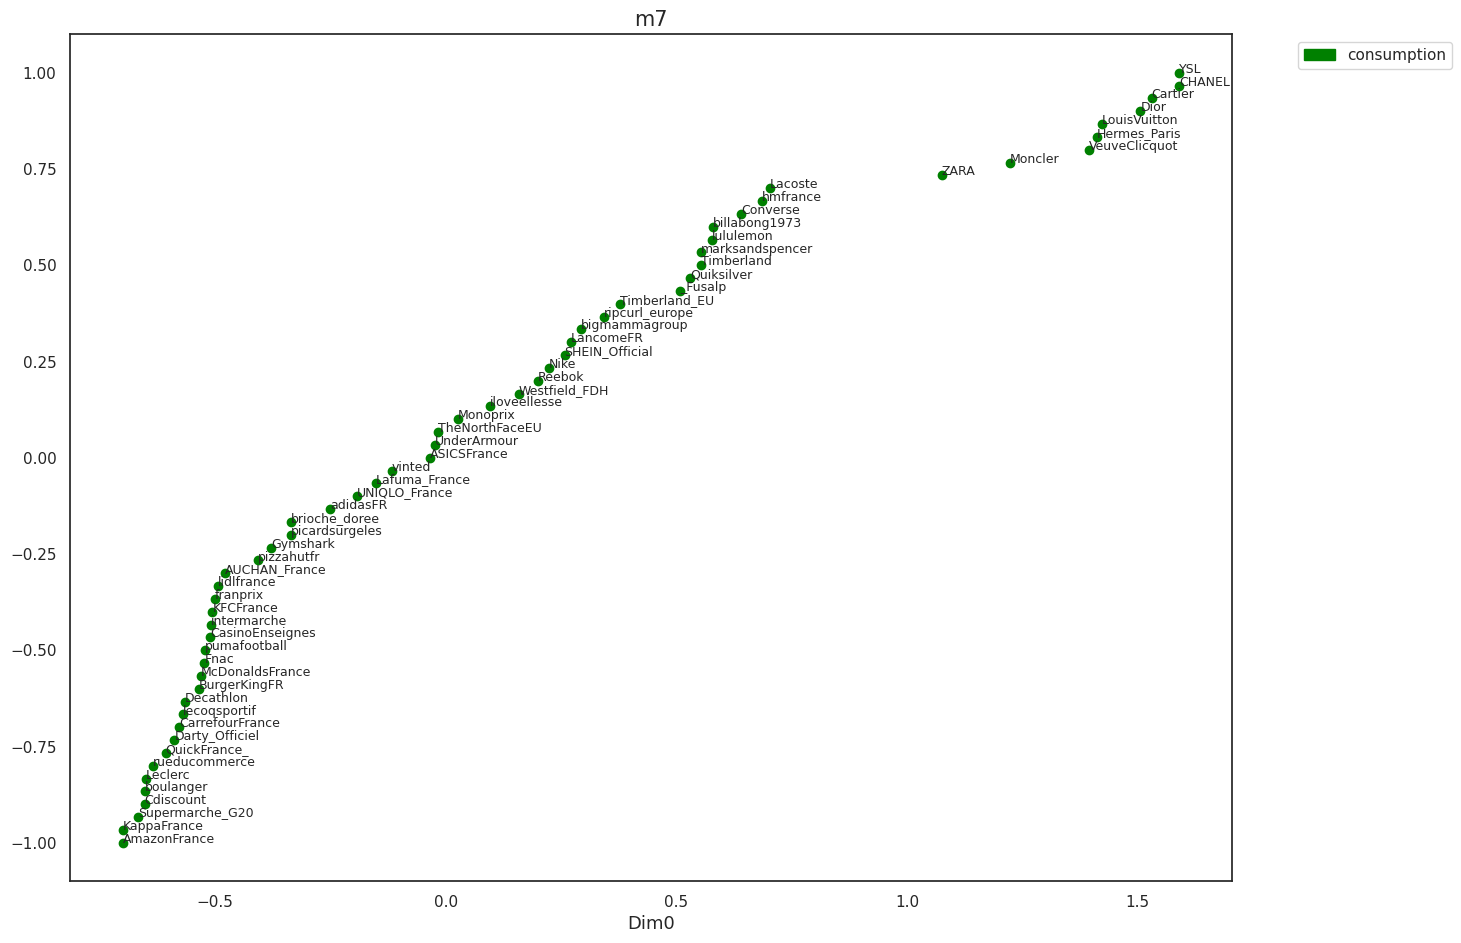

In [112]:
import numpy as np
import matplotlib.patches as mpatches

# Select the last DataFrame
df = dfs[-1]

# Create a new figure
plt.figure(figsize=(15, 11))

# Define the color dictionary
color_dict = {'consumption': 'green'}

# Sort the DataFrame by the '0' column
df = df.sort_values('0')

# Generate evenly spaced y-values for the markers
y_values = np.linspace(-1, 1, len(df))

# Add scatterplot for each 'twitter_name' in the DataFrame
for name in df['twitter_name'].unique():
    name_subset = df[df['twitter_name'] == name]
    type2_color = color_dict[name_subset['type2'].iloc[0]]  # Get the color for the current type2
    plt.scatter(name_subset['0'], y_values[df['twitter_name'] == name], color=type2_color)
    # Add label to the plot
    for x, y in zip(name_subset['0'], y_values[df['twitter_name'] == name]):
        plt.text(x, y, name, fontsize=9)

# Set the labels and title
plt.xlabel('Dim0', size=13)
plt.title('m7', size=15)

# Create a legend
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in color_dict.items()]
plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

### Job distribution

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

df = job_coords[1].copy()

# Create color categories
df['color'] = df['PCS_ESE'].str[0].astype(int)

# Calculate median income for each group and sort groups by this value
group_order = df.groupby('color')['Salaire_moyen_en_EQTP'].median().sort_values().index

# Define a color map
color_map = {str(i): plt.cm.Set1((i-2) / 4.) for i in range(2, 7)}

fig, ax = plt.subplots(figsize=(15, 10))

# Boxplot for each color category
sns.boxplot(x='color', y='Salaire_moyen_en_EQTP', data=df, palette=color_map, ax=ax, order=group_order)

ax.set_title('Income Distribution per Job Group')
ax.set_xlabel('Job Group')
ax.set_ylabel('Income')

# Create custom legend handles
legend_handles = [mpatches.Patch(color=color_map[str(color)], label=f'PCE_ESE Class {color}') for color in group_order]
ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.patches as mpatches

# Define a color map
color_map = {str(i): plt.cm.Set1((i-2) / 4.) for i in range(2, 7)}

df = job_coords[1].copy()
df['color'] = df['PCS_ESE'].str[0].astype(str)  # Ungrouped data
grouped_df = df.groupby('PCS_ESE')[['0', outcome]].median()  # Grouped data
grouped_df['color'] = grouped_df.index.str[0].astype(str)
grouped_df['title'] = df.groupby('PCS_ESE')['title'].first()  # Get the title for each group

fig, ax = plt.subplots(figsize=(20, 15))

# Calculate correlation and adjust alpha based on it
corr, _ = spearmanr(grouped_df['0'], grouped_df[outcome])  # Use Spearman's correlation
alpha = 1.0 if abs(corr) >= 0.25 else 0.2  # Decrease alpha for low correlation

# Grouped data
for color in color_map.keys():
    subset = grouped_df[grouped_df['color'] == color]
    for i, point in subset.iterrows():
        ax.scatter(point['0'], point[outcome], color=color_map[color], alpha=alpha)
        ax.text(point['0'], point[outcome], point['title'], fontsize=10)  # Add text annotation

ax.set_xlabel('0')
ax.set_ylabel(outcome)

# Add correlation as text annotation
if abs(corr) >= 0.25:
    ax.text(0.1, 0.9, f'Corr: {corr:.2f}', transform=ax.transAxes, weight='bold')
else:
    ax.text(0.1, 0.9, f'Corr: {corr:.2f}', transform=ax.transAxes)
    ax.patch.set_alpha(0.3)  # Lower the alpha for other plots

ax.set_title(f'm2:')

# Create custom legend handles
legend_handles = [mpatches.Patch(color=color_map[color], label=f'PCE_ESE Class {color}') for color in color_map.keys()]
ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.tight_layout()
plt.show()

In [ ]:

outcome = 'Salaire_moyen_en_EQTP'
predictors = ['0', '1', '2']
# Define a color map
color_map = {str(i): plt.cm.Set1((i-2) / 4.) for i in range(2, 7)}

# Get unique color categories
color_categories = np.unique(np.concatenate([df['PCS_ESE'].str[0].unique() for df in job_coords]))

# Create a grid of plots
fig, axes = plt.subplots(3, 3, figsize=(16, 16))

axes = axes.flatten()  # Flatten the axes array to loop over it

for i, df in enumerate(job_coords):
    df = df.copy()
    df['color'] = df['PCS_ESE'].str[0].astype(str)  # Ungrouped data
    grouped_df = df.groupby('PCS_ESE')[['0', outcome]].median()  # Grouped data
    grouped_df['color'] = grouped_df.index.str[0].astype(str)
    
    ax = axes[i]  # Corrected indexing here

    # Calculate correlation and adjust alpha based on it
    corr, _ = spearmanr(grouped_df['0'], grouped_df[outcome])  # Use Spearman's correlation
    alpha = 1.0 if abs(corr) >= 0.25 else 0.2  # Decrease alpha for low correlation

    # Grouped data
    for color in color_categories:
        ax.scatter(grouped_df.loc[grouped_df['color'] == color, '0'], 
                   grouped_df.loc[grouped_df['color'] == color, outcome], 
                   color=color_map[color], alpha=alpha, label=f'PCE_ESE Class {color}')
    sns.regplot(x=grouped_df['0'], y=grouped_df[outcome], 
                color='black', scatter=False, ci=95, line_kws={'linewidth': '1', 'alpha': alpha}, ax=ax)
    ax.set_xlabel('0')
    ax.set_ylabel(outcome)

    # Add correlation as text annotation
    if abs(corr) >= 0.25:
        ax.text(0.1, 0.9, f'Corr: {corr:.2f}', transform=ax.transAxes, weight='bold')
    else:
        ax.text(0.1, 0.9, f'Corr: {corr:.2f}', transform=ax.transAxes)
        ax.patch.set_alpha(0.3)  # Lower the alpha for other plots

    ax.set_title(f'm{i+1}:')

# Create custom legend handles
legend_handles = [mlines.Line2D([], [], color=color_map[color], marker='o', linestyle='None',
                                 markersize=10, label=f'PCE_ESE Class {color}') for color in color_categories]
ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

fig.suptitle('Average Monthly Income vs SES', fontsize=16)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.patches as mpatches

df = job_coords[1].copy()
df['color'] = df['PCS_ESE'].str[0].astype(str)  # Ungrouped data
grouped_df = df.groupby('PCS_ESE')[['0', outcome]].median()  # Grouped data
grouped_df['color'] = grouped_df.index.str[0].astype(str)
grouped_df['title'] = df.groupby('PCS_ESE')['title'].first()  # Get the title for each group

fig, ax = plt.subplots(figsize=(20, 15))

# Calculate correlation and adjust alpha based on it
corr, _ = spearmanr(grouped_df['0'], grouped_df[outcome])  # Use Spearman's correlation
alpha = 1.0 if abs(corr) >= 0.25 else 0.2  # Decrease alpha for low correlation

# Define color categories and color map
color_categories = sorted(df['color'].unique())
color_map = {str(i): plt.cm.Set1((i-2) / 4.) for i in color_categories}

# Grouped data
for color in color_categories:
    subset = grouped_df[grouped_df['color'] == color]
    for i, point in subset.iterrows():
        ax.scatter(point['0'], point[outcome], color=color_map[color], alpha=alpha)
        ax.text(point['0'], point[outcome], point['title'], fontsize=10)  # Add text annotation

ax.set_xlabel('0')
ax.set_ylabel(outcome)

# Add correlation as text annotation
if abs(corr) >= 0.25:
    ax.text(0.1, 0.9, f'Corr: {corr:.2f}', transform=ax.transAxes, weight='bold')
else:
    ax.text(0.1, 0.9, f'Corr: {corr:.2f}', transform=ax.transAxes)
    ax.patch.set_alpha(0.3)  # Lower the alpha for other plots

ax.set_title(f'm2:')

# Create custom legend handles
legend_handles = [mpatches.Patch(color=color_map[color], label=f'PCE_ESE Class {color}') for color in color_categories]
ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_title_distributions(df, *titles, alpha=0.5):
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']  # Add more colors if needed

    for i, title in enumerate(titles):
        # Filter the dataframe for rows where 'title' is the current title
        df_title = df[df['title'] == title]

        # Plot the distribution of '0' for the current title
        sns.kdeplot(df_title['0'], color=colors[i % len(colors)], label=title, fill=True, alpha=alpha)

    plt.xlabel('0')
    plt.ylabel('Density')
    plt.title('Coordinate comparison for different job titles')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [ ]:
def plot_PCS_ESE_name_distributions(df, PCS_ESE_code_to_name, *PCS_ESE_codes, alpha=0.5):
    # Get a color palette with as many colors as there are PCS_ESE_codes
    colors = sns.color_palette('hsv', n_colors=len(PCS_ESE_codes))

    for i, PCS_ESE_code in enumerate(PCS_ESE_codes):
        # Filter the dataframe for rows where 'PCS_ESE' is the current PCS_ESE_code
        df_PCS_ESE = df[df['PCS_ESE'] == PCS_ESE_code]

        # Get the corresponding name for the current PCS_ESE_code
        PCS_ESE_name = PCS_ESE_code_to_name[PCS_ESE_code]

        # Plot the distribution of '0' for the current PCS_ESE_code
        sns.kdeplot(df_PCS_ESE['0'], color=colors[i], label=PCS_ESE_name, fill=True, alpha=alpha)

    plt.xlabel('0')
    plt.ylabel('Density')
    plt.title('Coordinate comparison for different PCS_ESEs')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [ ]:
# Create a dictionary mapping PCS_ESE codes to names
PCS_ESE_code_to_name = dict(zip(job_coords[1]['PCS_ESE'], job_coords[1]['PCS_ESE_name']))

# Call the function with the PCS_ESE codes
plot_PCS_ESE_name_distributions(job_coords[1], PCS_ESE_code_to_name, '478a', '424a', '636c', '526a', '467a', '431f', '533a', '210x', '354f', '376g', '461d', '432d', '374b', '354b', '354a', '344d', '354c', '375b', '352a', '465a', '372e', '542a', '632a', '523c', '344b', '312a', '372a', '382b', '381b', '311d', '372f', '351a', '342h', '342f', '342b', alpha=0.06)

### Inspection of extreme ends